## __Ocean salinity investigation:__

### __Hands-on tutorial of AWS in-region access of NASA Earthdata products__

This notebook provides a basic workflow to interact with data "in-place" from the NASA Earthdata Cloud, by accessing AWS s3 locations provided by NASA Harmony outputs without the need to download data. *More info on benefits and differences between this workflow and "traditional" download workflows...*. 

#### Learning objectives:
- 
- 
- 


#### __First, some background on our different AWS access methods...__

- Harmony: Need access keys
- CMR direct access: (maybe not showing this in this notebook),
- MUR data in AWS OpenRegistry

#### __Set up for in-region access__

__This notebook must be running within an EC2 instance running in us-west-2__

For the live AGU Workshop, our BinderHub instance already takes care of steps 1 and 2, but these instructions are provided so that you can set this up in your own AWS account outside of the workshop.

1. Follow tutorials 01 through 03 of the [NASA Earthdata Cloud Primer](https://earthdata.nasa.gov/learn/user-resources/webinars-and-tutorials/cloud-primer) to set up an EC2 instance within us-west-2. Ensure you are also following step 3 in the ["Jupyter Notebooks on AWS EC2 in 12 (mostly easy) steps"](https://medium.com/@alexjsanchez/python-3-notebooks-on-aws-ec2-in-15-mostly-easy-steps-2ec5e662c6c6) article to set the correct security group settings needed to connect your local port to your EC2’s notebook port thru SSH.

2. Follow the remaining instructions in the Medium article above, which includes installation of Anaconda3 (including Jupyter Lab) in your ec2 instance. Before moving over to Jupyter Lab, perform steps 3 - 4 to set up Earthdata Login and Harmony access:

3. Setup your `~/.netrc` for Earthdata Login in your ec2 instance:

`machine uat.earthdata.nasa.gov login <user> password <password>`

4. Run the following in your ec2 instance terminal window to generate short-term Harmony access keys:

`curl -Ln -bj https://harmony.earthdata.nasa.gov/cloud-access.sh`

5. Set your environment variables based on the keys provided in step 4:

`export AWS_ACCESS_KEY_ID='...
export AWS_SECRET_ACCESS_KEY='...'
export AWS_SESSION_TOKEN='...'
export AWS_DEFAULT_REGION='us-west-2'`

6. Once the notebook is running in Jupyter Lab, run the following cell to install Python dependencies, import necessary modules, and set notebook defaults:

In [ ]:
# %load_ext autoreload
# %autoreload
# %matplotlib inline

# import sys
# # Install dependencies into the Jupyter Kernel
# !{sys.executable} -m pip install -q -r notebook_helpers/requirements.txt
# #!{sys.executable} -m pip install intake-stac # if you don't already have intake-stac

# # Import libraries used throughout the notebook
# from notebook_helpers import get, post, show, get_data_urls, show_async, show_async_condensed, print_async_status, show_shape
# import json
# import intake
# import s3fs

# import json

In [1]:
import tutorial_helper_functions as fn
from pprint import pprint

### __Earthdata Login__

In [2]:
# Get your authentication token for searching restricted records in the CMR:
_token = fn.setup_cmr_token_auth(endpoint="cmr.earthdata.nasa.gov")

# Start authenticated session with URS to allow restricted data downloads:
fn.setup_earthdata_login_auth(endpoint="urs.earthdata.nasa.gov")

Username:  amy.steiker
Password:  ·········


### __CMR Search/Discovery__

In [ ]:
# search_parameters = { 
#     'smap': {'short_name': 'SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V4','version': '4.0', 'provider': 'POCLOUD','bounding_box': bounding_box,'temporal': temporal},
#     'modis': {'short_name': 'MODIS_T-JPL-L2P-v2019.0','version': '2019.0','provider': 'POCLOUD','bounding_box': bounding_box,'temporal': temporal},
#     'mur': {'short_name': 'xx','version': 'xx','provider': 'xx','bounding_box': bounding_box,'temporal': temporal},
#             }


### __SMAP Sea Surface Salinity__

Zarr reformatting

In [21]:
smap_collection_id='C1940468263-POCLOUD'
harmony_root = 'https://harmony.earthdata.nasa.gov'
params = {
    'collection_id': smap_collection_id,
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'format': 'application/x-zarr',
    'start': '2020-11-15T00:00:00.000Z',
    'stop':'2020-11-15T23:59:59.000Z'
}

smap_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?format={format}&subset=time("{start}":"{stop}")'.format(**params)

In [22]:
smap_results = fn.get_harmony_results(smap_url, _token)

Request URL https://harmony.earthdata.nasa.gov/C1940468263-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?format=application/x-zarr&subset=time("2020-11-15T00:00:00.000Z":"2020-11-15T23:59:59.000Z")


KeyError: 'jobID'

In [ ]:
pprint(smap_results)

#### __Explore the STAC response using `intake-stac`__

Each asynchronous request response includes a [STAC](https://stacspec.org/) catalog that contains spatial and temporal metadata for each output, or STAC item. These metadata fields now reflect the values of the subsetted outputs themselves, providing transformation metadata for users. The [Pangeo gallery](http://gallery.pangeo.io/repos/pangeo-data/pangeo-tutorial-gallery/intake.html) includes great guidance on how to work with stac catalogs to access cloud-hosted data in place.

In [ ]:
smap_results = json.loads(response.content)
job = results['jobID']
print(job)

stac_root = 'https://harmony.earthdata.nasa.gov/stac/{jobID}/{item}'

__Open STAC Catalog from Harmony response__

Two STAC items are listed, corresponding to the two outputs plotted above.

In [ ]:
stac_cat = intake.open_stac_catalog(stac_root.format(jobID=job,item=''),name='Harmony output')
display(list(stac_cat))
list(stac_cat)[0]

We can inspect the metadata of each STAC item, which includes the bounding box, coordinates, and start and end time:

In [ ]:
for i in range(len(list(stac_cat))):
    display(intake.open_stac_item(stac_root.format(jobID=job,item=i)))

Each item can be accessed from the harmony s3 staging bucket:

In [ ]:
entries = []
for id, entry in stac_cat.search('type').items():
    display(entry)
    entries.append(entry)

### __Access Harmony outputs directly from STAC__

The Harmony output image is loaded up into an xarray data array directly from the STAC catalog.

In [ ]:
smap_da = stac_cat[list(stac_cat)[0]][entries[0].describe()['name']].to_dask()
smap_da

In [ ]:
smap_da.plot.imshow()

### __MODIS SST__

#### __On your own activity since this mimics same SMAP workflow??__

Spatial subsetting

In [ ]:
modis_collection_id='C1940475563-POCLOUD'
harmony_root = 'https://harmony.earthdata.nasa.gov'
params = {
    'collection_id': modis_collection_id,
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'lat':,
    'lon':
#    'format': 'application/x-zarr',
    'start': '2020-11-15T00:00:00.000Z',
    'stop':'2020-11-15T23:59:59.000Z'
}

harmony_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?format={format}&subset=time("{start}":"{stop}")'.format(**params)

In [ ]:
modis_results = fn.get_harmony_results(modis_url, _token)

In [ ]:
pprint(modis_results)

Open VIA STAC...

### __MUR SST__

Already reformatted to Zarr in AWS Open Registry

Adapted from https://github.com/pangeo-gallery/osm2020tutorial

In [18]:
# $ conda install -c conda-forge zarr
!{sys.executable} -m pip install zarr
!{sys.executable} -m pip install aiohttp

import warnings
import numpy as np
import pandas as pd
import xarray as xr
import fsspec
import requests

     |████████████████████████████████| 643 kB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 123 kB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 48 kB 11.0 MB/s eta 0:00:01


In [19]:
ds_sst = xr.open_zarr('https://mur-sst.s3.us-west-2.amazonaws.com/zarr-v1',consolidated=True)

ds_sst

,Array,Chunk
Bytes,16.70 TB,129.53 MB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,141791 Tasks,141790 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,16.70 TB,129.53 MB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,141791 Tasks,141790 Chunks
Type,float32,numpy.ndarray


#### Explore data

In [23]:
sst = ds_sst['analysed_sst']

cond = (ds_sst.mask==1) & ((ds_sst.sea_ice_fraction<.15) | np.isnan(ds_sst.sea_ice_fraction))
sst_masked = ds_sst['analysed_sst'].where(cond)

In [24]:
%%time
sst_day = sst_masked.sel(time='2015-10-01',lat=slice(20,65),lon=slice(-170,-110)).load()

CPU times: user 10.9 s, sys: 2.91 s, total: 13.8 s
Wall time: 23.8 s


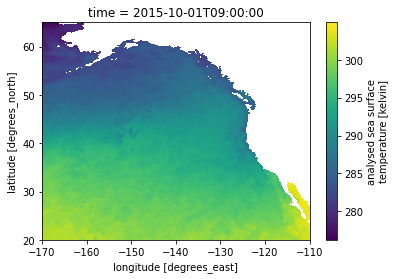

In [25]:
sst_day.plot()

### __Data Harmonization__

- analyze across data sets?
- Plot together?

### __Time Series across a large data set__

Climatology or some large data request to show power of cloud??

Stage in public s3 for this?? Or grab from Cumulus staging bucket?